In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from statsmodels.tsa.stattools import grangercausalitytests

Instructions for updating:
non-resource variables are not supported in the long term


c:\Users\artur\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Tensorflow version:", tf.__version__)
print("SHAP version:", shap.__version__)

NumPy version: 1.19.5
Pandas version: 1.3.5
Tensorflow version: 2.4.1
SHAP version: 0.38.1


# 1 - Data Preprocessing

In [3]:
def processar_dados_ano(caminho_arquivo, escolas_comuns):
    df = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')   
    df = df[(df['TP_DEPENDENCIA'] != 4) & (df["CO_MUNICIPIO"] == 2704302)]

    df = df[df['CO_ENTIDADE'].isin(escolas_comuns)]
    colunas_para_remover = [col for col in df.columns if (col.startswith('DS_') or col.startswith('NU_') or col.startswith('DT_') or col.startswith('CO_') or col.startswith('NO_')) and col != 'NU_ANO_CENSO']
    df_limpo = df.drop(columns=colunas_para_remover).drop(columns=['SG_UF'])
    colunas_com_nan = df_limpo.columns[df_limpo.isnull().any()].tolist()
    return df_limpo, colunas_com_nan

diretorio = 'dataset/'
primeiro_ano = 2008
caminho_arquivo = f'{diretorio}microdados_ed_basica_{primeiro_ano}_alagoas.csv'
df_primeiro_ano = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')
escolas_comuns = set(df_primeiro_ano['CO_ENTIDADE'].unique())

for ano in range(primeiro_ano + 1, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')
    escolas_comuns = escolas_comuns.intersection(set(df['CO_ENTIDADE'].unique()))
dfs = [] 

matriculas_por_ano_med = []
qt_salas_por_ano = []
qt_funcionarios_por_ano = []
qt_doc_med_por_ano = []
qt_turma_med_por_ano = []
qt_lab_por_ano = []
qt_computador_por_ano = []
qt_computador_aluno_por_ano = []
quadra_esporte_por_ano = []
anos = range(primeiro_ano, 2022)

for ano in anos:
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df_limpo, colunas_com_nan = processar_dados_ano(caminho_arquivo, escolas_comuns)
    dfs.append(df_limpo)

    qt_funcionarios = df_limpo['QT_FUNCIONARIOS'].sum()
    qt_lab_med = df_limpo['IN_LABORATORIO_CIENCIAS'].sum()
    quadra_esporte = df_limpo['IN_QUADRA_ESPORTES'].sum()
    mat_med = df_limpo['QT_MAT_MED'].sum()
    qt_doc_med = df_limpo['QT_DOC_MED'].sum()
    qt_turma_med = df_limpo['QT_TUR_MED'].sum()
    qt_computador = df_limpo['QT_COMPUTADOR'].sum()
    qt_computador_aluno = df_limpo['QT_COMP_ALUNO'].sum()
    

    
    matriculas_por_ano_med.append(mat_med)
    qt_funcionarios_por_ano.append(qt_funcionarios)
    qt_lab_por_ano.append(qt_lab_med)
    qt_doc_med_por_ano.append(qt_doc_med)
    qt_turma_med_por_ano.append(qt_turma_med)
    qt_computador_por_ano.append(qt_computador)
    qt_computador_aluno_por_ano.append(qt_computador_aluno)
    quadra_esporte_por_ano.append(quadra_esporte)


    
    print(f"Resumo dos dados de {ano}:")
    print(colunas_com_nan)
    print("--------------------------------------------------------------------\n")
    print(df_limpo.describe())

df_consolidado = pd.concat(dfs, ignore_index=True)

Resumo dos dados de 2008:
[]
--------------------------------------------------------------------

       NU_ANO_CENSO  TP_DEPENDENCIA  TP_CATEGORIA_ESCOLA_PRIVADA  \
count         228.0      228.000000                        228.0   
mean         2008.0        2.535088                          0.0   
std             0.0        0.508601                          0.0   
min          2008.0        1.000000                          0.0   
25%          2008.0        2.000000                          0.0   
50%          2008.0        3.000000                          0.0   
75%          2008.0        3.000000                          0.0   
max          2008.0        3.000000                          0.0   

       TP_LOCALIZACAO  TP_LOCALIZACAO_DIFERENCIADA  TP_SITUACAO_FUNCIONAMENTO  \
count      228.000000                        228.0                      228.0   
mean         1.004386                          0.0                        1.0   
std          0.066227                        

In [4]:
correlacao = df_consolidado.corr()

limiar_correlacao = 0.3

correlacoes_fortes_qt_mat_bas = correlacao['QT_MAT_MED'][np.abs(correlacao['QT_MAT_MED']) > limiar_correlacao]

variaveis_fortes_lista = correlacoes_fortes_qt_mat_bas.index.drop('QT_MAT_MED').tolist()

variaveis_fortes_lista.append('QT_MAT_MED')
print(variaveis_fortes_lista)
corr = df_consolidado[variaveis_fortes_lista].corr()
csv = corr.to_csv('correlacao_med.csv')

['TP_DEPENDENCIA', 'IN_LABORATORIO_CIENCIAS', 'IN_QUADRA_ESPORTES', 'QT_SALAS_EXISTENTES', 'QT_SALAS_UTILIZADAS', 'QT_COMP_ALUNO', 'QT_COMPUTADOR', 'QT_COMP_ADMINISTRATIVO', 'QT_FUNCIONARIOS', 'IN_FUND_AI', 'IN_MED', 'IN_PROF_TEC', 'IN_EJA_MED', 'QT_MAT_BAS', 'QT_MAT_FUND_AI', 'QT_MAT_FUND_AF', 'QT_MAT_PROF', 'QT_MAT_PROF_TEC', 'QT_MAT_EJA_MED', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_ND', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_6_10', 'QT_MAT_BAS_11_14', 'QT_MAT_BAS_15_17', 'QT_MAT_BAS_18_MAIS', 'QT_MAT_BAS_D', 'QT_MAT_BAS_N', 'QT_DOC_BAS', 'QT_DOC_FUND_AI', 'QT_DOC_FUND_AF', 'QT_DOC_MED', 'QT_DOC_PROF', 'QT_DOC_PROF_TEC', 'QT_DOC_EJA_MED', 'QT_DOC_ESP', 'QT_DOC_ESP_CC', 'QT_TUR_BAS', 'QT_TUR_FUND_AI', 'QT_TUR_FUND_AF', 'QT_TUR_MED', 'QT_TUR_PROF', 'QT_TUR_PROF_TEC', 'QT_TUR_EJA_MED', 'QT_MAT_MED']


In [5]:
dados_ano = {'NU_ANO_CENSO': list(anos), 'QT_MAT_MED': matriculas_por_ano_med, 'QT_DOC_MED': qt_doc_med_por_ano, 'QT_TUR_MED': qt_turma_med_por_ano,'IN_LABORATORIO_CIENCIAS':qt_lab_por_ano, 'QT_FUNCIONARIOS': qt_funcionarios_por_ano, 'QT_COMPUTADOR': qt_computador_por_ano,'QT_COMP_ALUNO': qt_computador_aluno_por_ano, 'IN_QUADRA_ESPORTES': quadra_esporte_por_ano}
df_consolidado = pd.DataFrame(dados_ano)
features = df_consolidado.drop(columns=['QT_MAT_MED', 'NU_ANO_CENSO']).values
target = df_consolidado['QT_MAT_MED'].values.reshape(-1, 1)

In [6]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
target_normalized = scaler_target.fit_transform(target)

In [7]:
def create_sliding_window(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)
window_size = 2

X, y = create_sliding_window(features_normalized, target_normalized, window_size)

In [8]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# 2 - Training the Model

In [9]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))  
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.05))
model.add(LSTM(units=110))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=512, verbose=0, validation_data=(X_test, y_test))


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


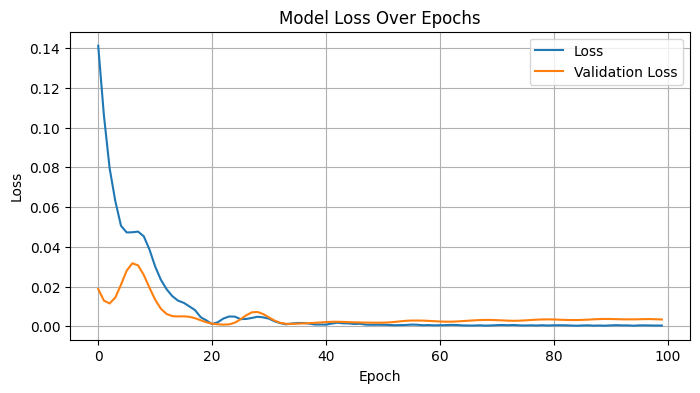

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
train_index = list(range(window_size, split + window_size))
test_index = list(range(split + window_size, len(df_consolidado)))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_rescaled = scaler_target.inverse_transform(
    np.concatenate([train_predict, np.zeros((train_predict.shape[0], 1))], axis=-1)
)[:, 0]

test_predict_rescaled = scaler_target.inverse_transform(
    np.concatenate([test_predict, np.zeros((test_predict.shape[0], 1))], axis=-1)
)[:, 0]

y_test_rescaled = scaler_target.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))], axis=-1)
)[:, 0]

In [12]:
mae = mean_absolute_error(y_test_rescaled, test_predict_rescaled)
mse = mean_squared_error(y_test_rescaled, test_predict_rescaled)
rsme = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, test_predict_rescaled)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rsme:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 393.32
RMSE: 575.13
MSE: 330769.46
R2: 0.36


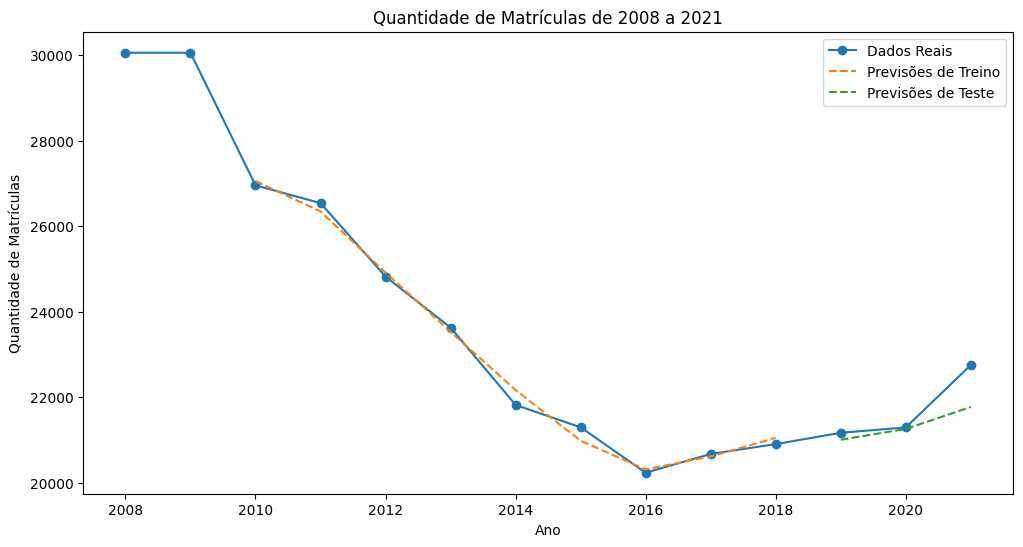

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_consolidado['NU_ANO_CENSO'], df_consolidado['QT_MAT_MED'], label='Dados Reais', marker='o')
plt.plot(df_consolidado['NU_ANO_CENSO'][train_index], train_predict_rescaled, label='Previsões de Treino', linestyle='--')
plt.plot(df_consolidado['NU_ANO_CENSO'][test_index], test_predict_rescaled, label='Previsões de Teste', linestyle='--')
plt.title('Quantidade de Matrículas de 2008 a 2021')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Matrículas')
plt.legend()
plt.show()

# 3 - SHAP

Formato de X_train: (9, 2, 7)
Formato de X_test: (3, 2, 7)



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


Dimensões dos shap_values: 1 (3, 2, 7)
Formato do shap_aggregated: (3, 7)


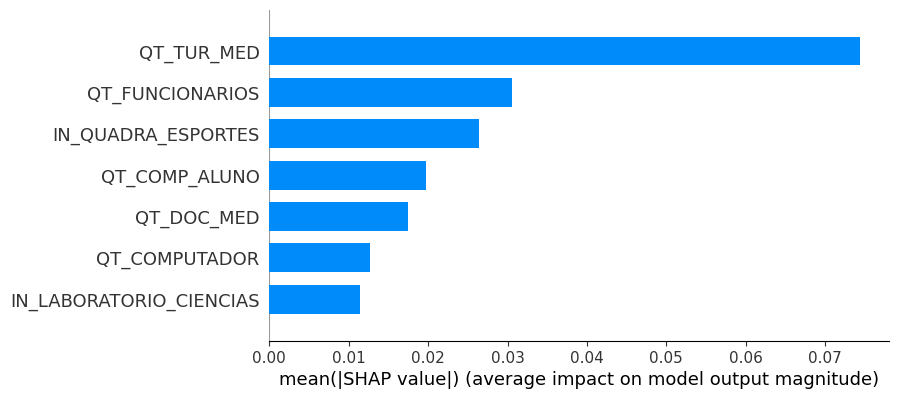

In [14]:
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

print("Formato de X_train:", X_train_np.shape)
print("Formato de X_test:", X_test_np.shape)

explainer = shap.DeepExplainer(model, X_train_np)

shap_values = explainer.shap_values(X_test_np)

print("Dimensões dos shap_values:", len(shap_values), shap_values[0].shape)

shap_aggregated = np.mean(shap_values[0], axis=1)

print("Formato do shap_aggregated:", shap_aggregated.shape)

feature_names = ['QT_DOC_MED', 'QT_TUR_MED','IN_LABORATORIO_CIENCIAS','QT_FUNCIONARIOS','QT_COMPUTADOR','QT_COMP_ALUNO','IN_QUADRA_ESPORTES'] 

if shap_aggregated.shape[1] != len(feature_names):
    raise ValueError("Número de features no shap_aggregated e feature_names não corresponde.")

shap.summary_plot(shap_aggregated, plot_type='bar', feature_names=feature_names)

plt.show()

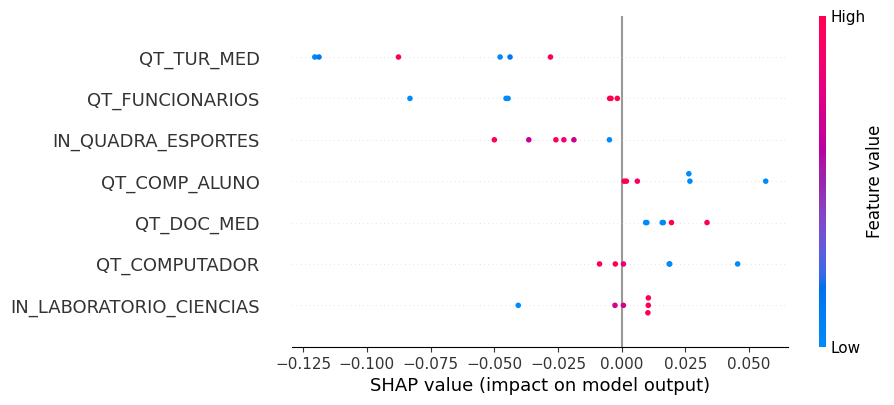

In [16]:
shap_values_flat = shap_values[0].reshape(shap_values[0].shape[0] * shap_values[0].shape[1], shap_values[0].shape[2])
X_test_flat = X_test_np.reshape(X_test_np.shape[0] * X_test_np.shape[1], X_test_np.shape[2])

shap.summary_plot(shap_values_flat, features=X_test_flat, feature_names=feature_names)



In [17]:
# Dados
data = {
    'QT_MAT_MED': matriculas_por_ano_med, 
    'QT_DOC_MED': qt_doc_med_por_ano,
    'QT_TUR_MED': qt_turma_med_por_ano,
    'IN_LABORATORIO_CIENCIAS': qt_lab_por_ano,
    'QT_FUNCIONARIOS': qt_funcionarios_por_ano,
    'QT_COMPUTADOR': qt_computador_por_ano,
    'QT_COMP_ALUNO': qt_computador_aluno_por_ano,
    'IN_QUADRA_ESPORTES': quadra_esporte_por_ano
}

df = pd.DataFrame(data)

# Remover colunas constantes
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"Coluna constante encontrada: {column} - Valor: {df[column].iloc[0]}")

df = df.loc[:, df.nunique() > 1]

print("Dados após remoção de colunas constantes:")
print(df.head())

# Função para criar matriz de causalidade de Granger
maxlag = 3
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, significance_level=0.05):
    """ Cria uma matriz de causalidade de Granger mostrando os valores-p para cada par de variáveis."""
    df_result = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df_result.columns:
        for r in df_result.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_result.loc[r, c] = min_p_value
    
    df_result.columns = [var + '_x' for var in variables]
    df_result.index = [var + '_y' for var in variables]

    # Adicionar um indicador de causalidade significativa
    significance_matrix = df_result < significance_level
    return df_result, significance_matrix

# Aplicando o teste de causalidade de Granger
causation_matrix, significance_matrix = grangers_causation_matrix(df, variables=df.columns, verbose=True)

print("Matriz de Causalidade de Granger (valores-p):")
print(causation_matrix)

print("\nMatriz de Causalidade Significativa (True para causalidade significativa):")
print(significance_matrix)



Dados após remoção de colunas constantes:
   QT_MAT_MED  QT_DOC_MED  QT_TUR_MED  IN_LABORATORIO_CIENCIAS  \
0       30054        1373         762                       51   
1       30054        1333         746                       54   
2       26953        1339         703                       54   
3       26537        1348         680                       53   
4       24818        1189         653                       51   

   QT_FUNCIONARIOS  QT_COMPUTADOR  QT_COMP_ALUNO  IN_QUADRA_ESPORTES  
0            13353           1801           1070                  72  
1            13294           2235           1655                  73  
2            13051           2701           2055                  74  
3            13006           4161           3221                  67  
4            12505           3652           2839                  70  
Y = QT_MAT_MED, X = QT_MAT_MED, P Values = [1.0, 1.0, 1.0]
Y = QT_DOC_MED, X = QT_MAT_MED, P Values = [0.0637, 0.1261, 0.0004]
Y = QT_T

verbose is deprecated since functions should not print results


Y = QT_COMPUTADOR, X = QT_DOC_MED, P Values = [0.0185, 0.0059, 0.0]
Y = QT_COMP_ALUNO, X = QT_DOC_MED, P Values = [0.0165, 0.0125, 0.0]
Y = IN_QUADRA_ESPORTES, X = QT_DOC_MED, P Values = [0.8513, 0.8425, 0.0748]
Y = QT_MAT_MED, X = QT_TUR_MED, P Values = [0.0549, 0.0001, 0.0016]
Y = QT_DOC_MED, X = QT_TUR_MED, P Values = [0.0813, 0.0854, 0.0352]
Y = QT_TUR_MED, X = QT_TUR_MED, P Values = [1.0, 1.0, 1.0]
Y = IN_LABORATORIO_CIENCIAS, X = QT_TUR_MED, P Values = [0.439, 0.7432, 0.1532]
Y = QT_FUNCIONARIOS, X = QT_TUR_MED, P Values = [0.2797, 0.2761, 0.8567]
Y = QT_COMPUTADOR, X = QT_TUR_MED, P Values = [0.1442, 0.0033, 0.0126]
Y = QT_COMP_ALUNO, X = QT_TUR_MED, P Values = [0.0315, 0.0003, 0.0015]
Y = IN_QUADRA_ESPORTES, X = QT_TUR_MED, P Values = [0.0341, 0.0507, 0.0029]
Y = QT_MAT_MED, X = IN_LABORATORIO_CIENCIAS, P Values = [0.4494, 0.0, 0.0344]
Y = QT_DOC_MED, X = IN_LABORATORIO_CIENCIAS, P Values = [0.5545, 0.0042, 0.0019]
Y = QT_TUR_MED, X = IN_LABORATORIO_CIENCIAS, P Values = [0.5692